In [ ]:
#!pip install shap

In [3]:
# import pandas for data wrangling
import pandas as pd
import numpy as np
import shap

import xgboost as xgb
from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt
import seaborn as sns
import random

from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold, cross_val_score

from rdkit import Chem
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from mordred import Calculator, descriptors
import mordred
# Set the seed
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)


out='figs/'

In [4]:
#dataset = pd.read_csv('descriptors_total.csv')

#Sa autocorr
dataset = pd.read_csv('data/HSP_descriptors_NO_ERRS_ZEROS.csv',index_col=[0] )
#dataset.drop(['Unnamed: 0'],axis=1,inplace=True)
dataset


,al,CAS,smiles,ABC,ABCGG,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,δD,δP,δH
0,"1,1,1,2-Tetrachloroethane",b'630-20-6',ClCC(Cl)(Cl)Cl,4.012290,4.284816,5.818626,2.074313,4.148627,5.818626,0.969771,...,20.736383,28,3,24.0,22.0,4.312500,1.375000,18.0,4.4,4.2
1,"1,1,1-Trichloroethane",b'71-55-6',CC(Cl)(Cl)Cl,3.464102,3.464102,4.000000,2.000000,4.000000,4.000000,0.800000,...,16.491254,16,0,20.0,16.0,4.062500,1.000000,16.8,4.3,2.0
2,"1,1,1-Trifluoroethane",b'420-46-2',CC(F)(F)F,3.464102,3.464102,4.000000,2.000000,4.000000,4.000000,0.800000,...,10.502336,16,0,20.0,16.0,4.062500,1.000000,14.6,10.0,0.0
3,"1,1,2,2-Tetrabromoethane",b'79-27-6',BrC(Br)C(Br)Br,3.932653,4.244375,6.000000,2.000000,4.000000,6.000000,1.000000,...,42.711125,29,4,22.0,21.0,4.222222,1.444444,21.0,7.0,8.2
4,"1,1,2,2-Tetrachloroethane",b'79-34-5',ClC(Cl)C(Cl)Cl,3.932653,4.244375,6.000000,2.000000,4.000000,6.000000,1.000000,...,20.736383,29,4,22.0,21.0,4.222222,1.444444,18.8,5.1,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,Quinine,b'130-95-0',[H][C@@]1([C@@H](C2=CC=NC3=CC=C(C=C23)OC)O)C[C...,18.958632,14.851657,32.595631,2.494948,4.989896,32.595631,1.358151,...,6.753829,1286,42,132.0,161.0,7.000000,5.333333,19.0,6.6,11.0
1196,Sulfur Dioxide,b'9/5/7446',O=S=O,1.414214,1.414214,2.828427,1.414214,2.828427,2.828427,0.942809,...,21.320633,4,0,6.0,4.0,2.250000,1.000000,15.8,8.4,10.0
1197,Thionyl Chloride,b'9/7/7719',O=S(Cl)Cl,2.449490,2.449490,3.464102,1.732051,3.464102,3.464102,0.866025,...,29.476173,9,0,12.0,9.0,3.111111,1.000000,16.9,6.4,6.1
1198,Triethylene Glycol Monooleyl Ether,b'5274-66-8',COCCOCCOCCO,7.071068,6.765664,13.191508,1.931852,3.863703,13.191508,1.199228,...,6.077958,220,8,38.0,36.0,4.250000,3.000000,16.0,3.1,8.4


In [6]:
nfeats=10
D = f'trained_models/{nfeats}/MODEL_D_XGBOOST.json'
P = f'trained_models/{nfeats}/MODEL_P_XGBOOST.json'
H = f'trained_models/{nfeats}/MODEL_H_XGBOOST.json'

D_model = xgb.XGBRegressor(enable_categorical=True) #iz nekog razloga ovo treba. iako sam izbacila redove sa greskama i sve
D_model.load_model(D)

P_model = xgb.XGBRegressor(enable_categorical=True)
P_model.load_model(P)

H_model = xgb.XGBRegressor(enable_categorical=True)
H_model.load_model(H)

In [7]:
X = dataset.iloc[:,3:-3]
y = dataset.iloc[:,-3:]

y_D = y['δD']
y_P = y['δP']
y_H = y['δH']

In [8]:
D_features = pd.read_csv(f"trained_models/{str(nfeats)}/D_XGBOOST_NONONE_xgboost_feature_importances_nfeats{str(nfeats)}.csv")['Name']
P_features = pd.read_csv(f"trained_models/{str(nfeats)}/P_XGBOOST_NONONE_xgboost_feature_importances_nfeats{str(nfeats)}.csv")['Name']
H_features = pd.read_csv(f"trained_models/{str(nfeats)}/H_XGBOOST_NONONE_xgboost_feature_importances_nfeats{str(nfeats)}.csv")['Name']

X_D = X[D_features]
X_P = X[P_features]
X_H = X[H_features]

# SHAP

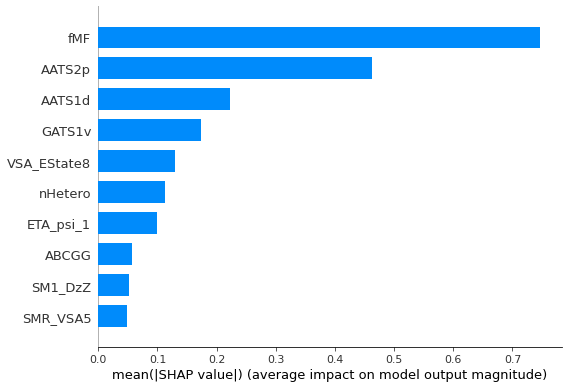

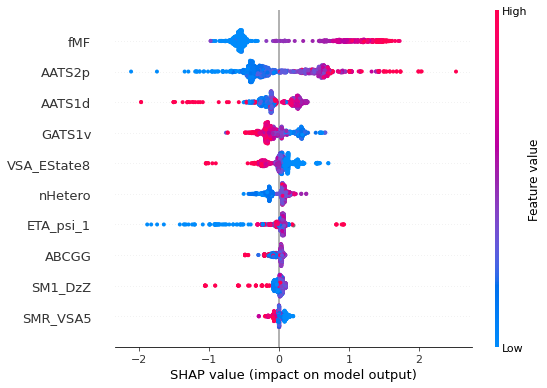

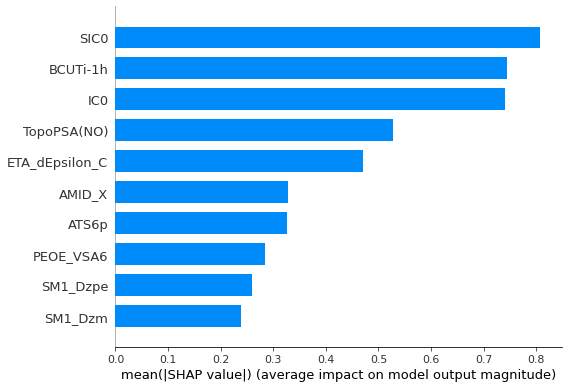

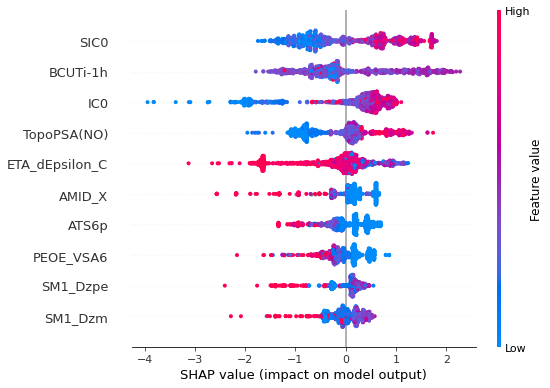

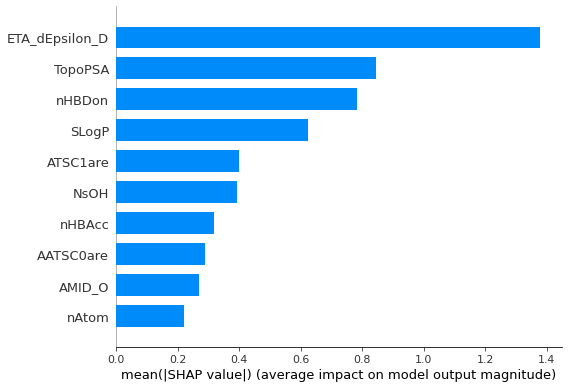

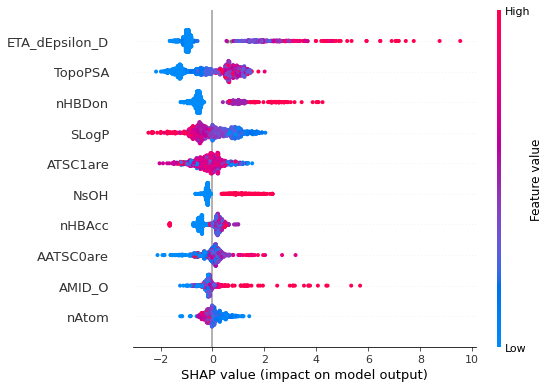

In [35]:
out_f="figs/"
toplot = {"D":[D_model,X_D],"P":[P_model,X_P],"H":[H_model,X_H]}
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
for key in toplot.keys():

    explainer = shap.TreeExplainer(toplot[key][0])
    shap_values = explainer.shap_values(toplot[key][1])
    fig, ax = plt.subplots() 
    shap.summary_plot(shap_values, toplot[key][1], plot_type="bar", show=False)
    fig.savefig(out_f+f"{key}_SHAP_bar.png",dpi=600)
    fig, ax = plt.subplots()
    shap.summary_plot(shap_values, toplot[key][1])
    fig.savefig(out_f+f"{key}_SHAP_all.png",dpi=600)

